In [1]:
from tqdm import tqdm

import scanpy as sc
import pandas as pd
import numpy as np

import scipy.sparse as sp

import sccellfie

from scanpy.readwrite import read

import os

import matplotlib.pyplot as plt

In [2]:
import mpl_fontkit as fk
fk.install("Lato")
fk.set_font("Lato")

Font name: `Lato`


In [3]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

### RNA-seq data

In [4]:
# Set the datasets source folder
datasets_by_tissue = "/lustre/scratch127/cellgen/cellgeni/projects/cellxgene_census_snapshot/2024-04-01/datasets_by_tissue/"
# Set the output directory

#output_directory= "/nfs/team292/eg22/Metabolic-Tasks/CELLxGENE/Run-sccellfie-v01_12-snapshot-Apr24//"
output_directory = '/lustre/scratch126/cellgen/team292/eg22/CELLxGENE/Run-sccellfie-V0_4_2-snapshot-Apr24/'

In [5]:
development_stages = []
tissues_per_dataset = dict()

In [6]:
records = []
cell_types = set()

# Loop through each h5ad file in the directory
for h5ad in tqdm([f for f in os.listdir(datasets_by_tissue) if f.endswith(".h5ad")]):
    h5ad_path = os.path.join(datasets_by_tissue, h5ad)
    adata = sc.read_h5ad(h5ad_path, backed='r')
    tissue = h5ad.replace(".h5ad","")
    df = adata.obs
    total_cells = df.shape[0]
    df_healthy = df.loc[df['disease'] == 'normal']
    df_disease = df.loc[df['disease'] != 'normal']
    healthy_cells = df_healthy.shape[0]
    disease_cells = df_disease.shape[0]
    development_stages.extend(df['development_stage'].unique().tolist())
    records.append((tissue, healthy_cells, disease_cells, len(df_healthy['cell_type'].unique()),
                    len(df_disease['cell_type'].unique()), len(df['cell_type'].unique())))
    cell_types = cell_types.union(set(df_healthy['cell_type'].unique().tolist()))
    
    if 'system' in tissue:
        tissues_per_dataset[tissue] = df['tissue'].unique().tolist()

100%|██████████| 53/53 [06:34<00:00,  7.45s/it]


In [14]:
tissues_per_dataset

{'skeletal_system': ['vault of skull', 'rib', 'bone spine'],
 'digestive_system': ['nasopharynx', 'hindgut'],
 'central_nervous_system': ['white matter of cerebellum'],
 'reproductive_system': ['gonad'],
 'respiratory_system': ['respiratory airway',
  'trachea',
  'bronchus',
  'epithelium of trachea'],
 'immune_system': ['tonsil']}

In [15]:
!ls $datasets_by_tissue -lSh

total 995G
-rwxr-xr-x 1 16821 1818 513G Apr 18  2024 brain.h5ad
-rwxr-xr-x 1 16821 1818 156G Apr 12  2024 blood.h5ad
-rwxr-xr-x 1 16821 1818  66G Apr 12  2024 lung.h5ad
-rwxr-xr-x 1 16821 1818  59G Apr 12  2024 eye.h5ad
-rwxr-xr-x 1 16821 1818  52G Apr 12  2024 breast.h5ad
-rwxr-xr-x 1 16821 1818  27G Apr 12  2024 heart.h5ad
-rwxr-xr-x 1 16821 1818  14G Apr 12  2024 liver.h5ad
-rwxr-xr-x 1 16821 1818  12G Apr 12  2024 kidney.h5ad
-rwxr-xr-x 1 16821 1818  11G Apr 12  2024 small_intestine.h5ad
-rwxr-xr-x 1 16821 1818 7.4G Apr 12  2024 respiratory_system.h5ad
-rwxr-xr-x 1 16821 1818 7.4G Apr 12  2024 skin_of_body.h5ad
-rwxr-xr-x 1 16821 1818 6.8G Apr 12  2024 reproductive_system.h5ad
-rwxr-xr-x 1 16821 1818 6.4G Apr 12  2024 endocrine_gland.h5ad
-rwxr-xr-x 1 16821 1818 6.0G Apr 12  2024 placenta.h5ad
-rwxr-xr-x 1 16821 1818 4.9G Apr 12  2024 bone_marrow.h5ad
-rwxr-xr-x 1 16821 1818 4.8G Apr 12  2024 lymph_node.h5ad
-rwxr-xr-x 1 16821 1818 4.6G Apr 12  2024 spleen.h5ad
-rwxr-xr-x 1 16821 1

In [16]:
adata.obs.head()

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
21164_2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,18456850,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,stromal cell,CL:0000499,52-year-old human stage,HsapDv:0000146,normal,PATO:0000461,...,bladder organ,UBERON:0018707,tissue,bladder organ,UBERON:0018707,1317.0,710,1.854930,7.255371,26392
21165_2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,18456851,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,stromal cell,CL:0000499,52-year-old human stage,HsapDv:0000146,normal,PATO:0000461,...,bladder organ,UBERON:0018707,tissue,bladder organ,UBERON:0018707,1003.0,612,1.638889,3.422577,26392
21166_2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,18456852,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,stromal cell,CL:0000499,52-year-old human stage,HsapDv:0000146,normal,PATO:0000461,...,bladder organ,UBERON:0018707,tissue,bladder organ,UBERON:0018707,746.0,468,1.594017,3.663519,26392
21167_2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,18456853,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,stromal cell,CL:0000499,52-year-old human stage,HsapDv:0000146,normal,PATO:0000461,...,bladder organ,UBERON:0018707,tissue,bladder organ,UBERON:0018707,1147.0,595,1.927731,7.057058,26392
21168_2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,18456854,2adb1f8a-a6b1-4909-8ee8-484814e2d4bf,microwell-seq,EFO:0030002,stromal cell,CL:0000499,52-year-old human stage,HsapDv:0000146,normal,PATO:0000461,...,bladder organ,UBERON:0018707,tissue,bladder organ,UBERON:0018707,1148.0,661,1.736762,4.427571,26392


In [80]:
tissues_df = pd.DataFrame.from_records(records, columns=['Tissue', 'Cell Number (No Disease)', 'Cell Number (Disease)', 
                                                         'Cell Type Number (No Disease)', 'Cell Type Number (Disease)', 'Total Cell Type Number'])

In [81]:
tissues_df.shape

(53, 6)

In [82]:
tissues_df.sort_values(by='Cell Number (No Disease)', ascending=False)

,Tissue,Cell Number (No Disease),Cell Number (Disease),Cell Type Number (No Disease),Cell Type Number (Disease),Total Cell Type Number
25,brain,10560614,3215741,100,100,133
11,blood,4938374,4925201,147,109,153
31,breast,2280877,100064,62,18,67
16,eye,2208227,7433,98,24,99
6,lung,1512380,2164845,201,77,205
30,heart,791411,768563,70,18,70
1,liver,748717,214230,127,50,137
34,skin_of_body,497148,0,113,0,113
9,kidney,492147,547676,138,80,147
35,small_intestine,454524,513784,145,67,154


In [83]:
tissue_exclude = ['digestive_system', 'respiratory_system']
tissue_replace = {'immune_system' : 'tonsil',
                  'central_nervous_system' : 'cerebellum', 
                  'reproductive_system' : 'early_gonad', 
                  'skeletal_system' : 'bones',
                  'bladder_organ' : 'bladder'
                 }

In [84]:
tissues_df = tissues_df.loc[~tissues_df['Tissue'].isin(tissue_exclude)]
tissues_df['Tissue'] = tissues_df['Tissue'].replace(tissue_replace)

In [85]:
tissues_df.to_csv('./Summary-snapshot-Apr24/Summary-Stats-CELLxGENE-Apr-2024.csv')

In [86]:
tissues_df.sum()

Tissue                           noselivertonguepleural_fluidmucosaboneslungpan...
Cell Number (No Disease)                                                  29368016
Cell Number (Disease)                                                     13577604
Cell Type Number (No Disease)                                                 3042
Cell Type Number (Disease)                                                    1069
Total Cell Type Number                                                        3244
dtype: object

In [87]:
len(cell_types)

656

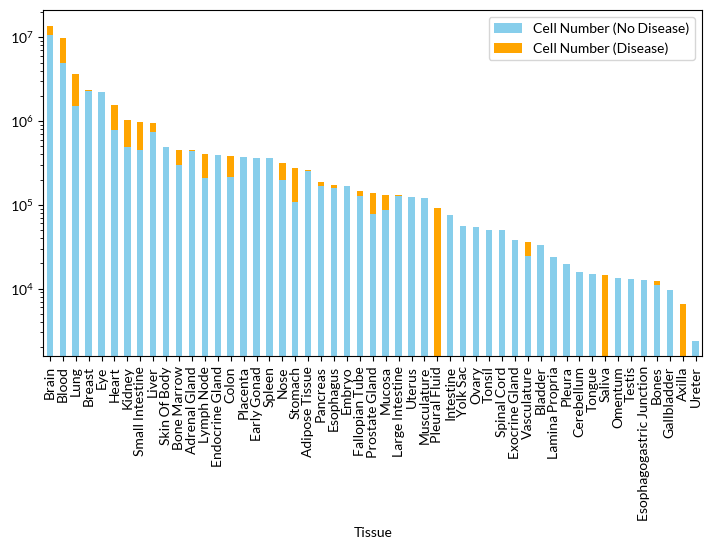

In [88]:
plot_df = tissues_df.copy()
plot_df['Total Cell Number'] = plot_df['Cell Number (No Disease)'] + plot_df['Cell Number (Disease)']
plot_df['Tissue'] = plot_df['Tissue'].str.title().str.replace('_', ' ')
plot_df.set_index('Tissue').sort_values(by='Total Cell Number', ascending=False)[['Cell Number (No Disease)', 'Cell Number (Disease)']].plot(kind='bar',
                                                                                                                                      stacked=True,
                                                                                                                                      color=['skyblue', 'orange'],
                                                                                                                                      figsize=(8.5, 4.5))
plt.yscale('log')
plt.savefig('./Summary-snapshot-Apr24/CELLxGENE_2024-04-01_cells.pdf', dpi=300, bbox_inches='tight')

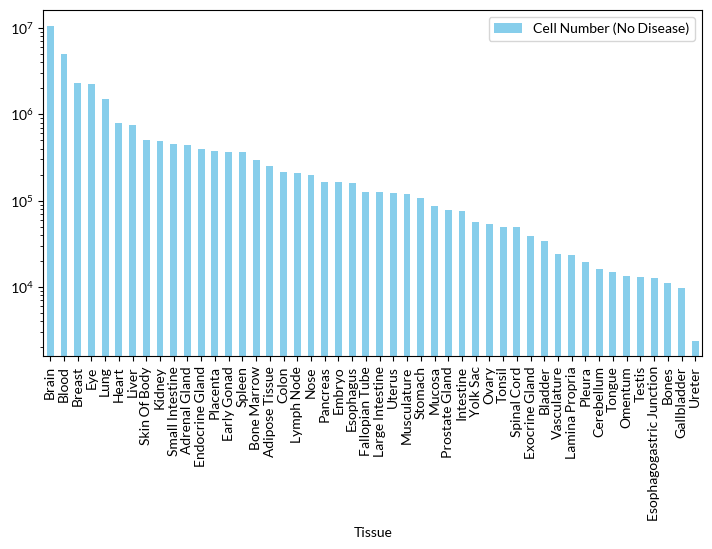

In [89]:
plot_df = tissues_df.copy()
plot_df['Total Cell Number'] = plot_df['Cell Number (No Disease)']
plot_df['Tissue'] = plot_df['Tissue'].str.title().str.replace('_', ' ')
plot_df = plot_df.set_index('Tissue').sort_values(by='Total Cell Number', ascending=False)[['Cell Number (No Disease)']]
plot_df = plot_df[plot_df['Cell Number (No Disease)'] != 0]

plot_df.plot(kind='bar', color='skyblue', figsize=(8.5, 4.5))
plt.yscale('log')
plt.savefig('./Summary-snapshot-Apr24/CELLxGENE_2024-04-01_healthy_cells.pdf', dpi=300, bbox_inches='tight')

In [92]:
labels = pd.read_excel('CELLxGENE-Labels.xlsx')
labels['Organ/System'] = [idx.title() for idx in labels['Organ/System'].values]
labels = labels.rename(columns={'Organ/System' : 'Tissue'})

In [93]:
import seaborn as sns
import glasbey

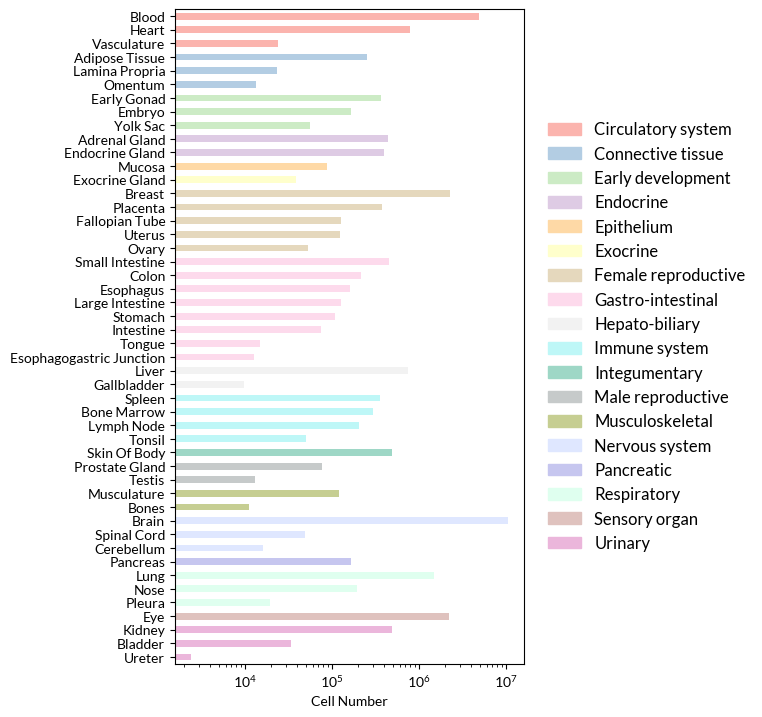

In [94]:
plot_df = tissues_df.copy()
y_name = 'Cell Number (No Disease)'
plot_df['Total Cell Number'] = plot_df[y_name ]
plot_df['Tissue'] = plot_df['Tissue'].str.title().str.replace('_', ' ')

# Merge the plot_df with the label_df based on the 'Tissue' column
plot_df = pd.merge(plot_df, labels, on='Tissue')

# Sort the tissues based on the specified label
plot_df = plot_df.sort_values(by=['Label', y_name], ascending=[False, True])

# Filter out tissues with zero cell numbers
plot_df = plot_df[plot_df[y_name] != 0]

# Specify the color palette
palette_name = 'Pastel1'  # Replace with your desired palette name

# Create a color palette based on the number of unique labels
unique_labels = sorted(plot_df['Label'].unique())
#palette = sns.color_palette(palette_name, len(unique_labels))
palette = glasbey.extend_palette(palette_name, palette_size=len(unique_labels))

# Create a dictionary mapping labels to colors
color_map = dict(zip(unique_labels, palette))

# Assign colors to each tissue based on its label
plot_df['Color'] = plot_df['Label'].map(color_map)

# Create a horizontal bar plot
plot_df.plot(kind='barh', x='Tissue', y=y_name, 
             color=plot_df['Color'], figsize=(4.5, 8.5), legend=False)

plt.xscale('log')
plt.xlabel('Cell Number')
plt.ylabel('')

# Create a legend for the labels
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[label]) for label in unique_labels]
plt.legend(handles, unique_labels, loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False, borderaxespad=0,)

plt.savefig('./Summary-snapshot-Apr24/CELLxGENE_2024-04-01_healthy_cells_horizontal.pdf', dpi=300, bbox_inches='tight')

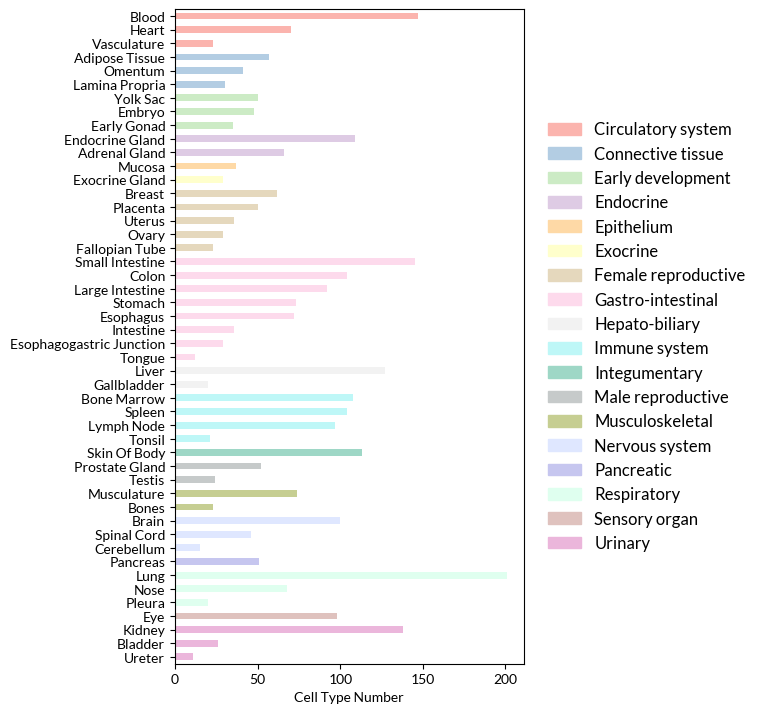

In [95]:
plot_df = tissues_df.copy()
y_name = 'Cell Type Number (No Disease)'
plot_df['Total Cell Number'] = plot_df[y_name ]
plot_df['Tissue'] = plot_df['Tissue'].str.title().str.replace('_', ' ')

# Merge the plot_df with the label_df based on the 'Tissue' column
plot_df = pd.merge(plot_df, labels, on='Tissue')

# Sort the tissues based on the specified label
plot_df = plot_df.sort_values(by=['Label', y_name], ascending=[False, True])

# Filter out tissues with zero cell numbers
plot_df = plot_df[plot_df[y_name] != 0]

# Specify the color palette
palette_name = 'Pastel1'  # Replace with your desired palette name

# Create a color palette based on the number of unique labels
unique_labels = sorted(plot_df['Label'].unique())
#palette = sns.color_palette(palette_name, len(unique_labels))
palette = glasbey.extend_palette(palette_name, palette_size=len(unique_labels))

# Create a dictionary mapping labels to colors
color_map = dict(zip(unique_labels, palette))

# Assign colors to each tissue based on its label
plot_df['Color'] = plot_df['Label'].map(color_map)

# Create a horizontal bar plot
plot_df.plot(kind='barh', x='Tissue', y=y_name, 
             color=plot_df['Color'], figsize=(4.5, 8.5), legend=False)

#plt.xscale('log')
plt.xlabel('Cell Type Number')
plt.ylabel('')

# Create a legend for the labels
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[label]) for label in unique_labels]
plt.legend(handles, unique_labels, loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=12, frameon=False, borderaxespad=0,)

plt.savefig('./Summary-snapshot-Apr24/CELLxGENE_2024-04-01_healthy_celltypes_horizontal.pdf', dpi=300, bbox_inches='tight')

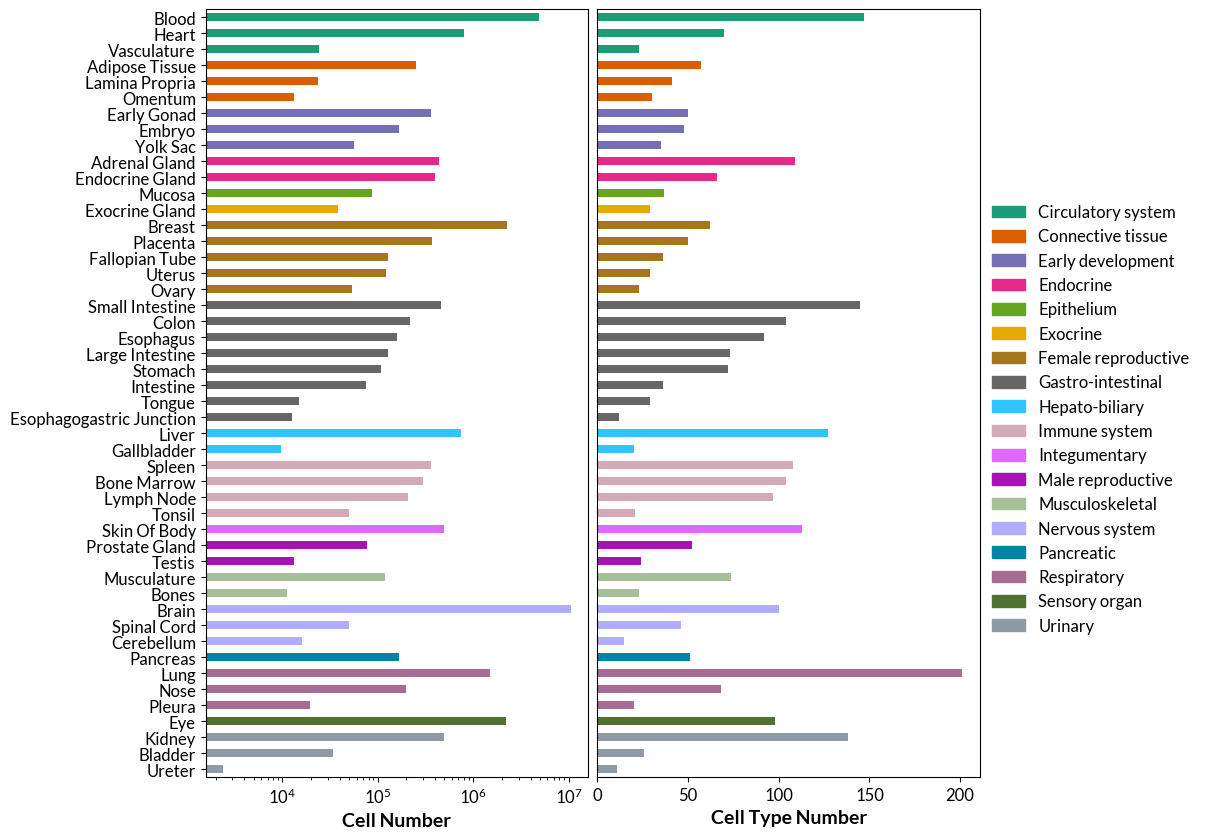

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8.5))

# Plot 1
plot_df1 = tissues_df.copy()
y_name1 = 'Cell Number (No Disease)'
plot_df1['Total Cell Number'] = plot_df1[y_name1]
plot_df1['Tissue'] = plot_df1['Tissue'].str.title().str.replace('_', ' ')
plot_df1 = pd.merge(plot_df1, labels, on='Tissue')
plot_df1 = plot_df1.sort_values(by=['Label', y_name1], ascending=[False, True])
plot_df1 = plot_df1[plot_df1[y_name1] != 0]
unique_labels = sorted(plot_df1['Label'].unique())
palette = glasbey.extend_palette('Dark2', palette_size=len(unique_labels))
color_map = dict(zip(unique_labels, palette))
plot_df1['Color'] = plot_df1['Label'].map(color_map)
plot_df1.plot(kind='barh', x='Tissue', y=y_name1, color=plot_df1['Color'], ax=ax1, legend=False)
ax1.set_xscale('log')
ax1.set_xlabel('Cell Number', fontsize=14, fontdict={'fontweight' : 'bold'})
ax1.set_ylabel('')
ax1.tick_params(axis='both', which='major', labelsize=12)


# Plot 2
plot_df2 = tissues_df.copy()
y_name2 = 'Cell Type Number (No Disease)'
plot_df2['Total Cell Number'] = plot_df2[y_name2]
plot_df2['Tissue'] = plot_df2['Tissue'].str.title().str.replace('_', ' ')
plot_df2 = pd.merge(plot_df2, labels, on='Tissue')
plot_df2 = plot_df2.sort_values(by=['Label', y_name2], ascending=[False, True])
plot_df2 = plot_df2[plot_df2[y_name2] != 0]
plot_df2['Color'] = plot_df2['Label'].map(color_map)
plot_df2.plot(kind='barh', x='Tissue', y=y_name2, color=plot_df2['Color'], ax=ax2, legend=False)
ax2.set_xlabel('Cell Type Number', fontsize=14, fontdict={'fontweight' : 'bold'})
ax2.set_ylabel('')
ax2.set_yticklabels([], fontsize=14)
ax2.set_yticks([])
ax2.tick_params(axis='both', which='major', labelsize=12)

# Create a legend for the labels
handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[label]) for label in unique_labels]
fig.legend(handles, unique_labels, loc="center left", bbox_to_anchor=(0.99, 0.5), fontsize=12, frameon=False, borderaxespad=0)

plt.subplots_adjust(right=0.85)
plt.tight_layout(w_pad=0.3)

plt.savefig('./Summary-snapshot-Apr24/CELLxGENE_2024-04-01_healthy_both_horizontal.pdf', dpi=300, bbox_inches='tight')

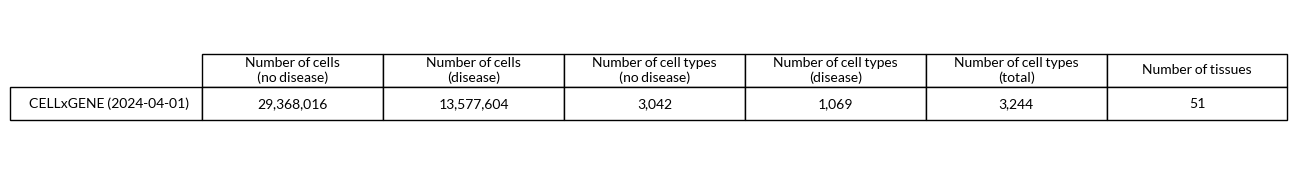

In [97]:
data = tissues_df.sum().values.tolist()[1:] + [tissues_df.shape[0]]
data = [['{:,}'.format(d) for d in data]]
columns = ['Number of cells\n(no disease)', 'Number of cells\n(disease)', 'Number of cell types\n(no disease)',
           'Number of cell types\n(disease)', 'Number of cell types\n(total)', 'Number of tissues']
row_label = ['CELLxGENE (2024-04-01)']

fig, ax = plt.subplots(figsize=(14, 2))
ax.axis('off')

table = ax.table(cellText=data, rowLabels=row_label, colLabels=columns, loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

#for key, cell in table.get_celld().items():
#    cell.get_text().set_fontfamily('Helvetica')
    
plt.savefig('./Summary-snapshot-Apr24/CELLxGENE_2024-04-01_table_normal_disease.pdf', dpi=300, bbox_inches='tight')

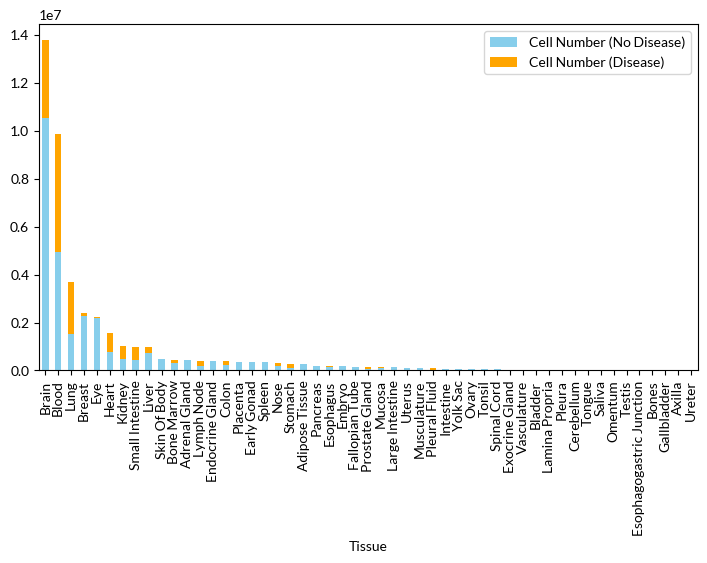

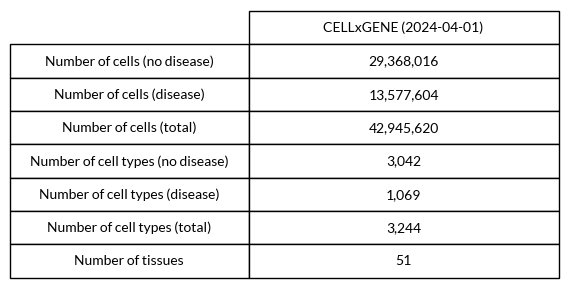

In [98]:
plot_df = tissues_df.copy()
plot_df['Total Cell Number'] = plot_df['Cell Number (No Disease)'] + plot_df['Cell Number (Disease)']
plot_df['Tissue'] = plot_df['Tissue'].str.title().str.replace('_', ' ')
plot_df.set_index('Tissue').sort_values(by='Total Cell Number', ascending=False)[['Cell Number (No Disease)', 'Cell Number (Disease)']].plot(kind='bar',
                                                                                                                                      stacked=True,
                                                                                                                                      color=['skyblue', 'orange'],
                                                                                                                                      figsize=(8.5, 4.5))
data = plot_df[['Tissue', 'Cell Number (No Disease)', 'Cell Number (Disease)', 'Total Cell Number', 
                'Cell Type Number (No Disease)', 'Cell Type Number (Disease)', 'Total Cell Type Number']].sum().values.tolist()[1:] + [tissues_df.shape[0]]
data = [['{:,}'.format(d)] for d in data]
row_label = ['Number of cells (no disease)', 'Number of cells (disease)', 'Number of cells (total)', 'Number of cell types (no disease)',
           'Number of cell types (disease)', 'Number of cell types (total)', 'Number of tissues']
columns = ['CELLxGENE (2024-04-01)']

fig, ax = plt.subplots(figsize=(4, 3.5))
ax.axis('off')

table = ax.table(cellText=data, rowLabels=row_label, colLabels=columns, loc='center', cellLoc='center', rowLoc='center', colLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

#for key, cell in table.get_celld().items():
#    cell.get_text().set_fontfamily('Helvetica')
    
plt.savefig('./Summary-snapshot-Apr24/CELLxGENE_2024-04-01_table_normal_disease_vertical.pdf', dpi=300, bbox_inches='tight')

In [99]:
import os
import pandas as pd

# Specify the folder path
folder_path = "/lustre/scratch126/cellgen/team292/eg22/CELLxGENE/Run-sccellfie-V0_4_2-snapshot-Apr24/"

# Initialize an empty list to store the results
results = []

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".out"):
        file_path = os.path.join(folder_path, filename)
        
        # Read the file contents
        with open(file_path, "r") as file:
            file_contents = file.read()
        
        # Check if "Successfully completed" is present in the file
        if "Successfully completed" in file_contents:
            status = "Completed"
        elif ("job killed" in file_contents) | ("Exited with exit code 1" in file_contents):
            status = 'Failed'
        else:
            status = "Running"
        
        # Extract the first part of the filename before the dot
        first_part = filename.split(".")[0]
        
        # Append the result to the list
        results.append([first_part, status])

# Create a pandas DataFrame from the results
df = pd.DataFrame(results, columns=["Filename", "Status"])

# Print the DataFrame
print(df.sort_values('Filename'))
print('\nTotal: {}'.format(df.shape[0]))

                    Filename     Status
39            adipose_tissue  Completed
9              adrenal_gland  Completed
46                    axilla  Completed
40             bladder_organ  Completed
30                     blood  Completed
15               bone_marrow  Completed
48                     brain  Completed
17                    breast  Completed
21    central_nervous_system  Completed
0                      colon  Completed
8           digestive_system  Completed
7                     embryo  Completed
10           endocrine_gland  Completed
50  esophagogastric_junction  Completed
19                 esophagus  Completed
20            exocrine_gland  Completed
45                       eye  Completed
23            fallopian_tube  Completed
37               gallbladder  Completed
16                     heart  Completed
35             immune_system  Completed
36                 intestine  Completed
3                     kidney  Completed
24            lamina_propria  Completed


In [100]:
[f + '.h5ad' for f in df[df['Status'] == 'Failed']['Filename'].values]

[]

In [101]:
df['Status'].value_counts()

Status
Completed    53
Name: count, dtype: int64

In [102]:
a = sc.read_h5ad(datasets_by_tissue + 'blood.h5ad', backed='r')

In [103]:
a.obs.head(1)

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
0_b0e547f0-462b-4f81-b31b-5b0a5d96f537,49371654,b0e547f0-462b-4f81-b31b-5b0a5d96f537,10x 5' v2,EFO:0009900,"CD16-positive, CD56-dim natural killer cell, h...",CL:0000939,57-year-old human stage,HsapDv:0000151,normal,PATO:0000461,...,blood,UBERON:0000178,tissue,blood,UBERON:0000178,3771.0,1718,2.194994,22.956131,33599


In [104]:
a.obs.tissue.unique()

['blood', 'umbilical cord blood', 'venous blood']
Categories (3, object): ['blood', 'umbilical cord blood', 'venous blood']

In [105]:
for ct, df in a.obs.groupby('cell_type'):
    print(ct, df.shape[0])

B cell 752171
CD1c-positive myeloid dendritic cell 17443
CD4-positive helper T cell 31854
CD4-positive, CD25-positive, alpha-beta regulatory T cell 454
CD4-positive, alpha-beta T cell 930294
CD4-positive, alpha-beta cytotoxic T cell 37745
CD4-positive, alpha-beta memory T cell 112790
CD4-positive, alpha-beta thymocyte 5858
CD8-positive, alpha-beta T cell 890339
CD8-positive, alpha-beta cytokine secreting effector T cell 1493
CD8-positive, alpha-beta cytotoxic T cell 88495
CD8-positive, alpha-beta memory T cell 98059
CD8-positive, alpha-beta memory T cell, CD45RO-positive 635
CD8-positive, alpha-beta thymocyte 2620
CD14-low, CD16-positive monocyte 87379
CD14-positive monocyte 561470
CD14-positive, CD16-negative classical monocyte 242543
CD14-positive, CD16-positive monocyte 9799
CD16-negative, CD56-bright natural killer cell, human 37608
CD16-positive, CD56-dim natural killer cell, human 279166
CD34-positive, CD38-negative hematopoietic stem cell 2238
CD141-positive myeloid dendritic ce

In [106]:
plot_df = tissues_df.copy()
y_name = 'Cell Type Number (No Disease)'
plot_df['Total Cell Number'] = plot_df[y_name ]
plot_df['Tissue'] = plot_df['Tissue'].str.title().str.replace('_', ' ')

# Merge the plot_df with the label_df based on the 'Tissue' column
plot_df = pd.merge(plot_df, labels, on='Tissue')

# Sort the tissues based on the specified label
plot_df = plot_df.sort_values(by=['Label', y_name], ascending=[True, False])

In [107]:
[l.lower().replace(' ', '_') for l in plot_df.Tissue.values]

['blood',
 'heart',
 'vasculature',
 'adipose_tissue',
 'omentum',
 'lamina_propria',
 'yolk_sac',
 'embryo',
 'early_gonad',
 'endocrine_gland',
 'adrenal_gland',
 'mucosa',
 'exocrine_gland',
 'breast',
 'placenta',
 'uterus',
 'ovary',
 'fallopian_tube',
 'small_intestine',
 'colon',
 'large_intestine',
 'stomach',
 'esophagus',
 'intestine',
 'esophagogastric_junction',
 'tongue',
 'liver',
 'gallbladder',
 'bone_marrow',
 'spleen',
 'lymph_node',
 'tonsil',
 'skin_of_body',
 'prostate_gland',
 'testis',
 'musculature',
 'bones',
 'brain',
 'spinal_cord',
 'cerebellum',
 'pancreas',
 'lung',
 'nose',
 'pleura',
 'eye',
 'kidney',
 'bladder',
 'ureter']